По замыслу A/B-теста контрольной группе (`control`) должна была показываться старая версия лендинга — `old_page`; экспериментальной группе (`treatment`) должна была показываться новая версия лендинга — `new_page`.

Вам следует:
1. понять структуру данных, провести EDA и выбрать метрику, с которой будете работать;
2. проверить корректность проведения тестирования (посмотреть на однородность групп; задуматься об A/A тесте; не забыть, что в нашем распоряжении есть еще и временные метки);
3. сформулировать нулевую и альтернативную гипотезы на основании выбранной метрики;
4. выбрать и обосновать статистический тест;
5. решить, нужно ли устаналивать значения каких-либо параметров до начала анализа тестирования;
6. оценить разницу в результатах и сделать выводы о практической значимости эксперимента;
7. провести дополнительный анализ при необходимости (например, с помощью [bootstrap](https://www.geeksforgeeks.org/maths/bootstrap-method/?utm_source=chatgpt.com)  или через анализ чувствительности);
- сформулировать рекомендации и бизнес-инсайты по результатам эксперимента.

**Важно**: это лишь возможные шаги для вашего исследования и воспринимать их следует как подсказки. Ваша центральная задача в любом случае представлена в общем виде — осуществить качественный и полный анализ результатов проведенного AB-тестирования.



Датасет состоит из пяти столбцов:

* `user_id` — уникальный идентификатор пользователя;

* `timestamp` — время посещения пользователем страницы;

* `group` — группа эксперимента, к которой был случайно отнесён пользователь:

  *   `control` — контрольная группа,
  *   `treatment` — экспериментальная группа;

* `landing_page` — версия лендинга, которую увидел пользователь:

  *   `old_page` — старая версия страницы,
  *   `new_page` — новая версия страницы;

* `converted` — бинарный признак, показывающий, совершил ли пользователь целевое действие (целевым действием является регистрация на курс).








In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.power import NormalIndPower
from scipy.stats import beta

## 1

In [2]:
df = pd.read_csv('data_ab.csv', sep=',')
print(df.shape)
df.head()

(294478, 5)


,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1


In [3]:
print("Пропущенные значения:")
print(df.isnull().sum())
print(f"Дубликатов user_id: {df['user_id'].duplicated().sum()}")

Пропущенные значения:
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64
Дубликатов user_id: 3894


In [4]:
groups = df['group'].value_counts()
print("Распределение по группам:")
print(groups)

Распределение по группам:
group
treatment    147276
control      147202
Name: count, dtype: int64


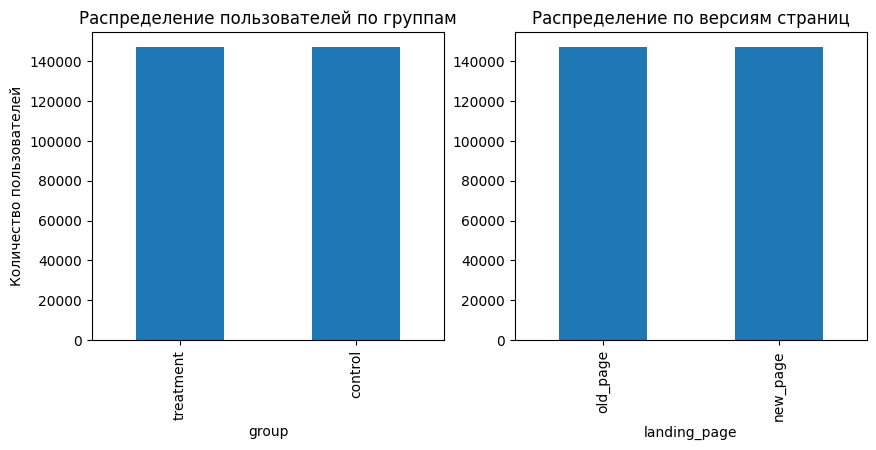

In [5]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
groups.plot(kind='bar')
plt.title('Распределение пользователей по группам')
plt.ylabel('Количество пользователей')

plt.subplot(1, 2, 2)
df['landing_page'].value_counts().plot(kind='bar')
plt.title('Распределение по версиям страниц')

plt.show()

Временные рамки эксперимента:
Начало: 2025-01-02 13:42:05.378582
Конец: 2025-01-24 13:41:54.460509
Длительность: 21 days 23:59:49.081927


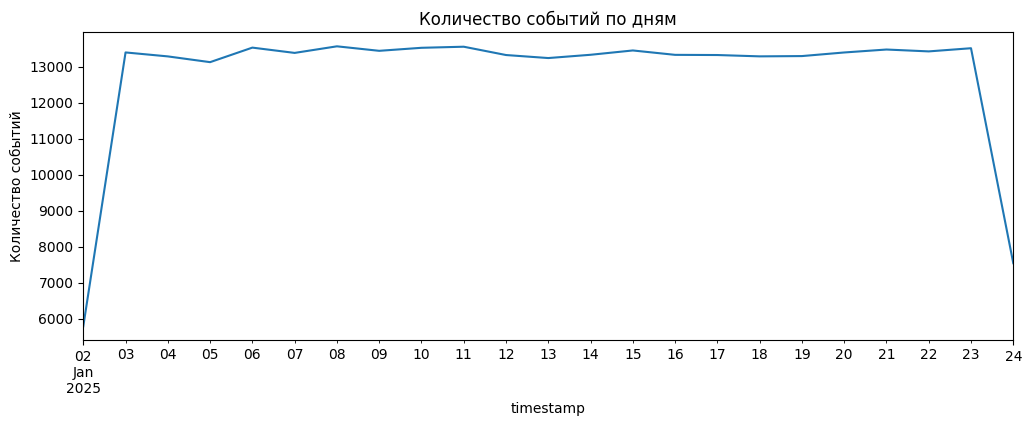

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
print("Временные рамки эксперимента:")
print(f"Начало: {df['timestamp'].min()}")
print(f"Конец: {df['timestamp'].max()}")
print(f"Длительность: {df['timestamp'].max() - df['timestamp'].min()}")

daily_events = df.set_index('timestamp').resample('D').size()
plt.figure(figsize=(12, 4))
daily_events.plot()
plt.title('Количество событий по дням')
plt.ylabel('Количество событий')
plt.show()

In [7]:
print(f"Общая конверсия: {df['converted'].mean()}")

con1 = df.groupby('group')['converted'].agg(['mean', 'count'])
print("Конверсия по группам:")
print(con1)

con2 = df.groupby('landing_page')['converted'].agg(['mean', 'count'])
print("Конверсия по версиям страниц:")
print(con2)

Общая конверсия: 0.11965919355605512
Конверсия по группам:
               mean   count
group                      
control    0.120399  147202
treatment  0.118920  147276
Конверсия по версиям страниц:
                  mean   count
landing_page                  
new_page      0.118841  147239
old_page      0.120478  147239


Ключевые выводы из EDA:
1. Качество данных:
* Нет пропущенных значений - данные чистые
* Есть дубликаты user_id (3894) - это требует дополнительного исследования
* Большой объем данных (~294k пользователей) - хорошая мощность для теста

2. Распределение по группам: Группы сбалансированы:
* control: 147,282 пользователей
* treatment: 147,276 пользователей

3. Временные рамки:
* Эксперимент длился 22 дня (с 2 по 24 января 2025)
* Равномерное распределение событий по времени - нет аномалий

Теперь разберемся с дубликатами и неправильными значениями. Обозначим, что control должны видеть только old_page, а treatment доолжны видеть только new_page.

In [8]:
df.duplicated(subset=['user_id']).sum()

np.int64(3894)

In [12]:
tab = pd.crosstab(df['group'], df['landing_page'])
print(tab)

landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145311      1965


In [13]:
df2 = df[((df['group'] == 'control') & (df['landing_page'] == 'old_page')) |
    ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))]

print(f"Финальный размер: {len(df2)}")

Финальный размер: 290585


In [14]:
tab = pd.crosstab(df2['group'], df2['landing_page'])
print(tab)

landing_page  new_page  old_page
group                           
control              0    145274
treatment       145311         0


Мы почистили датасет, оставили только правильные значения. Продолжаем работать с ним. Видим что остлся 1 дубликат, разберемся с ним.

In [15]:
df2[df2.duplicated(subset=['user_id'])==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2025-01-14 02:55:59.590927,treatment,new_page,0


In [16]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2025-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2025-01-14 02:55:59.590927,treatment,new_page,0


In [17]:
df2 = df2.drop_duplicates(subset='user_id', keep='first')

После следственного эксперимента оставили первое значение. У нас все столбцы одинаковое, всё ок. Ещё раз построим графики и сделаем выводы.

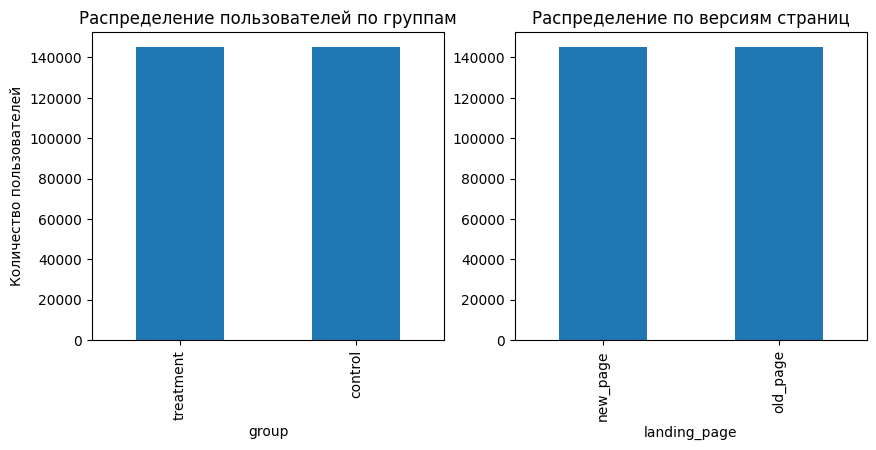

In [18]:
plt.figure(figsize=(10, 4))

groups2 = df2['group'].value_counts()
plt.subplot(1, 2, 1)
groups2.plot(kind='bar')
plt.title('Распределение пользователей по группам')
plt.ylabel('Количество пользователей')

plt.subplot(1, 2, 2)
df2['landing_page'].value_counts().plot(kind='bar')
plt.title('Распределение по версиям страниц')

plt.show()

Временные рамки эксперимента:
Начало: 2025-01-02 13:42:05.378582
Конец: 2025-01-24 13:41:54.460509
Длительность: 21 days 23:59:49.081927


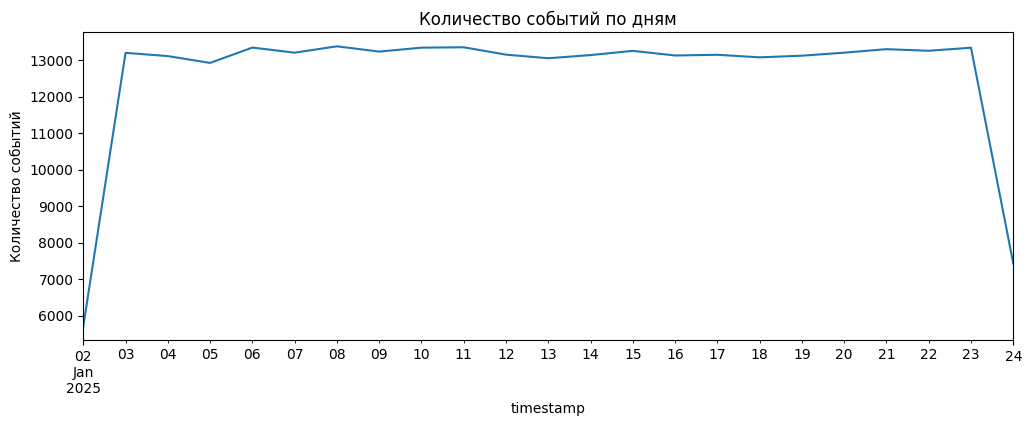

In [19]:
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
print("Временные рамки эксперимента:")
print(f"Начало: {df2['timestamp'].min()}")
print(f"Конец: {df2['timestamp'].max()}")
print(f"Длительность: {df2['timestamp'].max() - df2['timestamp'].min()}")

daily_events = df2.set_index('timestamp').resample('D').size()
plt.figure(figsize=(12, 4))
daily_events.plot()
plt.title('Количество событий по дням')
plt.ylabel('Количество событий')
plt.show()

In [20]:
print(f"Общая конверсия: {df2['converted'].mean()}")

con1 = df2.groupby('group')['converted'].agg(['mean', 'count'])
print("Конверсия по группам:")
print(con1)

con2 = df2.groupby('landing_page')['converted'].agg(['mean', 'count'])
print("Конверсия по версиям страниц:")
print(con2)

Общая конверсия: 0.11959708724499628
Конверсия по группам:
               mean   count
group                      
control    0.120386  145274
treatment  0.118808  145310
Конверсия по версиям страниц:
                  mean   count
landing_page                  
new_page      0.118808  145310
old_page      0.120386  145274


данных стало меньще, но конверсия и среднее не изменились.

+ НАДО ДОБАВИТЬ И ПОСМОТРЕТЬ ЗНАЧЕНИЯ ШТУК КОТОРЫЕ МЫ ПОПНУЛИ И ПОНЯТЬ ВЛИЯЛИ ЛИ ОНИ НА КОНВЕРСИЮ

Выводы:

1. Распределение выборки
* Тест проводился корректно с точки зрения распределения пользователей: Контрольная группа: 145,274. Тестовая группа: 145,310 пользователей
* Аналогично распределены версии страниц: Old page: 145,274. New page: 145,310

2. Конверсия по группам
* Общая конверсия: 11.96%
* Контрольная группа: 12.04%
* Тестовая группа: 11.88%

3. Временной анализ
* Тест проводился с 2 по 24 января 2025 года (22 дня)
* Количество событий было относительно стабильным на протяжении всего теста. Отсутствуют явные аномалии или резкие изменения в трафике

4. Предварительный вывод: Новая версия страницы не только не улучшила, но и ухудшила конверсию. Это указывает на то, что: Новая страница менее эффективна в конвертации пользователей и изменения, внесенные в дизайн/контент, оказали негативное влияние на пользовательское поведение.

Метрика: Conversion Rate = Количество конвертированных пользователей / Общее количество пользователей

Обоснование выбора:
1. Соответствие бизнес-цели
* Целевое действие - регистрация на курс
* Прямое измерение эффективности лендинга

2. Статистические преимущества
* Бинарная метрика - подходит для z-test / chi-square
* Стабильность - менее чувствительна к выбросам
* Простота интерпретации

3. Практичность
* Понятна всем стейкхолдерам
* Легко отслеживать в будущем
* Стандартная метрика для A/B тестов лендингов

## 2

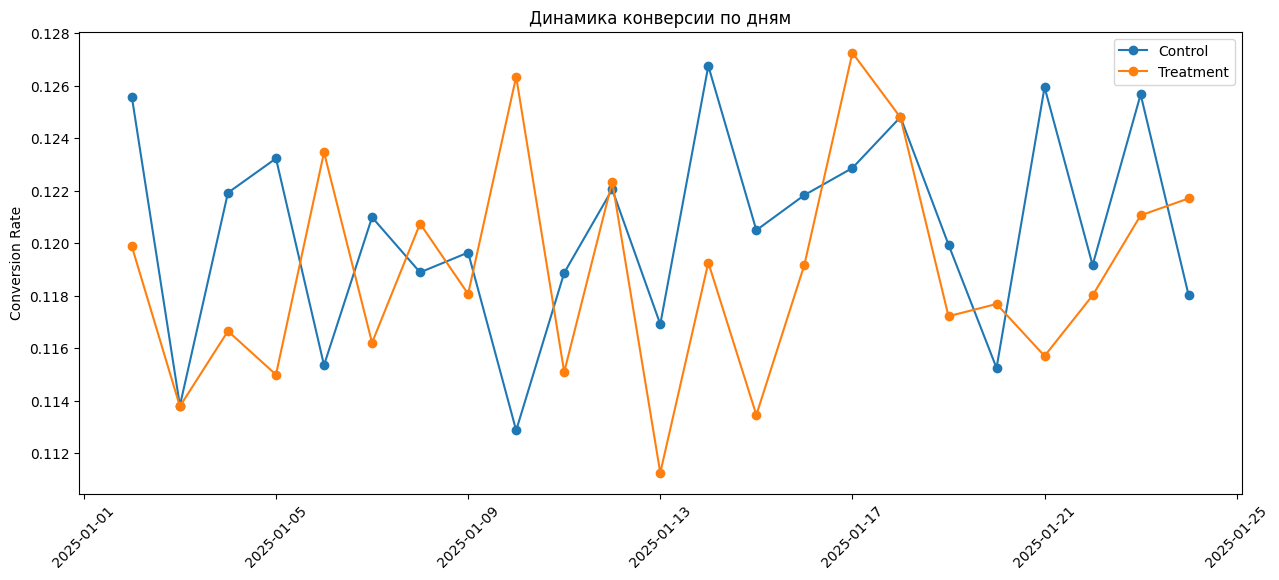

In [21]:
df2['date'] = df2['timestamp'].dt.date
daily_conversion = df2.groupby(['date', 'group'])['converted'].mean().unstack()

plt.figure(figsize=(15, 6))
plt.plot(daily_conversion.index, daily_conversion['control'], label='Control', marker='o')
plt.plot(daily_conversion.index, daily_conversion['treatment'], label='Treatment', marker='o')
plt.title('Динамика конверсии по дням')
plt.ylabel('Conversion Rate')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [23]:
control_data = df2[df2['group'] == 'control']
half_point = len(control_data) // 2

control_1 = control_data.iloc[:half_point]
control_2 = control_data.iloc[half_point:]

conv_1 = control_1['converted'].sum()
conv_2 = control_2['converted'].sum()
n1 = len(control_1)
n2 = len(control_2)

z_stat_aa, p_value_aa = proportions_ztest([conv_1, conv_2], [n1, n2])
print(f"A/A тест - Z-статистика: {z_stat_aa:.4f}, P-значение: {p_value_aa:.4f}")

A/A тест - Z-статистика: 0.2822, P-значение: 0.7778


<Figure size 1500x600 with 0 Axes>

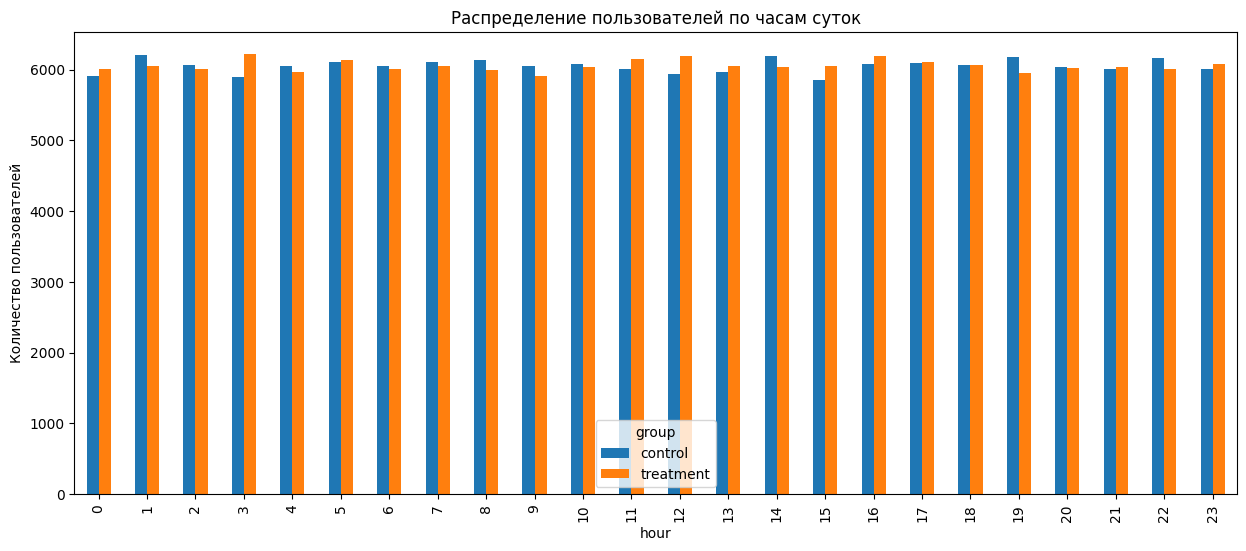

In [24]:
df2['hour'] = df2['timestamp'].dt.hour
dis = df2.groupby(['hour', 'group']).size().unstack()

plt.figure(figsize=(15, 6))
dis.plot(kind='bar', figsize=(15, 6))
plt.title('Распределение пользователей по часам суток')
plt.ylabel('Количество пользователей')
plt.show()

In [25]:
from scipy.stats import chi2_contingency

chi1, p_date1, dof1, expected1 = chi2_contingency(df2.groupby(['date', 'group']).size().unstack().fillna(0))
print(f"Хи-квадрат тест на равномерность по дням: p-value = {p_date1}")

chi2, p_hour2, dof2, expected2 = chi2_contingency(df2.groupby(['hour', 'group']).size().unstack().fillna(0))
print(f"Хи-квадрат тест на равномерность по часам: p-value = {p_hour2}")

Хи-квадрат тест на равномерность по дням: p-value = 0.9207631079105322
Хи-квадрат тест на равномерность по часам: p-value = 0.02900771459550439


1. A/A тест пройден. p-value = 0.7778 > 0.05

2. Группы равномерно распределены по дням. p-value = 0.92 > 0.05

3. Есть статистически значимые различия в распределении по часам суток. p-value = 0.029 < 0.05

4. Обе группы показывают параллельное поведение. Нет резких всплесков/провалов. Тренды согласованы

Проблема с распределением по часам (p-value = 0.029) может быть связана с естественными колебаниями трафика в течение суток или особенностями работы системы распределения в пиковое время. Однако поскольку A/A тест пройден и разница невелика, это не является критичной проблемой для валидности эксперимента.

## 3-5

Нулевая гипотеза (H₀): Конверсия в контрольной и экспериментальной группах не отличается.

Альтернативная гипотеза (H₁): Конверсия в контрольной и экспериментальной группах различается.

In [26]:
n_control = len(df2[df2['group'] == 'control'])
n_treatment = len(df2[df2['group'] == 'treatment'])
print(n_control, n_treatment)

145274 145310


Мы можем использовать Z-тест для пропорций, потому что выполняются все необходимые условия:

1. Большой объем данных - в каждой группе более 145,000 пользователей, что значительно превышает минимальные требования (n > 30)
2. Условия нормальности распределения выполняются:
* n × p > 5 и n × (1-p) > 5 для обеих групп
* При конверсии ~12% и n > 145,000: 145,000 × 0.12 ≈ 17,400 > 5
3. Независимые наблюдения - после очистки дубликатов каждый пользователь учитывается один раз, группы независимы
4. Случайная выборка - пользователи были рандомизированы в группы, что подтверждено A/A тестом

При таких объемах данных выборочное распределение разности пропорций стремится к нормальному даже при бинарной метрике, что делает Z-тест статистически обоснованным.

Преимущества Z-test:
* Высокая мощность при больших выборках
* Простая интерпретация результатов
* Позволяет построить доверительные интервалы
* Стандартный выбор для A/B тестов с бинарными метриками

Обязательно до начала теста установим значения некоторых параметров

1. Уровень значимости (α)
* α = 0.05 (стандартное значение для бизнес-экспериментов)
* Вероятность ошибки I рода (отклонить H₀, когда она верна)

2. Уровень мощности (1-β)
* 1-β = 0.8 (стандартное значение)
* Вероятность обнаружить эффект, если он действительно есть

3. Минимальный детектируемый эффект (MDE)
* MDE = 1% (относительное изменение конверсии)
* Или 0.2-0.5% абсолютного изменения (зависит от бизнес-контекста)

## 6

In [27]:
cr_control = df2[df2['group'] == 'control']['converted'].mean()
cr_treatment = df2[df2['group'] == 'treatment']['converted'].mean()

abs_diff = cr_treatment - cr_control
rel_diff = (cr_treatment - cr_control) / cr_control * 100

print(f"Конверсия control: {cr_control} ({cr_control*100}%)")
print(f"Конверсия treatment: {cr_treatment} ({cr_treatment*100}%)")
print(f"Абсолютная разница: {abs_diff} ({abs_diff*100}%)")
print(f"Относительная разница: {rel_diff}%")

Конверсия control: 0.1203863045004612 (12.03863045004612%)
Конверсия treatment: 0.11880806551510564 (11.880806551510565%)
Абсолютная разница: -0.0015782389853555567 (-0.15782389853555567%)
Относительная разница: -1.310978845894809%


In [29]:
control_converted = df2[df2['group'] == 'control']['converted'].sum()
treatment_converted = df2[df2['group'] == 'treatment']['converted'].sum()
control_total = len(df2[df2['group'] == 'control'])
treatment_total = len(df2[df2['group'] == 'treatment'])

count = [control_converted, treatment_converted]
nobs = [control_total, treatment_total]
z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

print(f"Z-статистика: {z_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

Z-статистика: 1.3109
P-значение: 0.1899


In [32]:
cr_control = control_converted / control_total
cr_treatment = treatment_converted / treatment_total

ci_control = proportion_confint(control_converted, control_total, alpha=0.05, method='normal')
ci_treatment = proportion_confint(treatment_converted, treatment_total, alpha=0.05, method='normal')

def diff_proportion_confint(conv1, n1, conv2, n2, alpha=0.05):
    p1 = conv1 / n1
    p2 = conv2 / n2
    se = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    z = 1.96
    diff = p2 - p1
    ci_lower = diff - z * se
    ci_upper = diff + z * se
    return ci_lower, ci_upper

ci_diff = diff_proportion_confint(control_converted, control_total,
                                 treatment_converted, treatment_total)

print("Конверсии по группам:")
print(f"Control: {cr_control:.4f} ({cr_control*100:.2f}%)")
print(f"Treatment: {cr_treatment:.4f} ({cr_treatment*100:.2f}%)")
print(f"Разница: {cr_treatment - cr_control:.4f} ({(cr_treatment - cr_control)*100:.2f}%)\n")

print("95% ДИ:")
print(f"Control: [{ci_control[0]:.4f}, {ci_control[1]:.4f}]")
print(f"Treatment: [{ci_treatment[0]:.4f}, {ci_treatment[1]:.4f}]")
print(f"Разница конверсий: [{ci_diff[0]:.4f}, {ci_diff[1]:.4f}]")

Конверсии по группам:
Control: 0.1204 (12.04%)
Treatment: 0.1188 (11.88%)
Разница: -0.0016 (-0.16%)

95% ДИ:
Control: [0.1187, 0.1221]
Treatment: [0.1171, 0.1205]
Разница конверсий: [-0.0039, 0.0008]


Статистическая значимость:
* P-value = 0.1899 > 0.05 → не отвергаем нулевую гипотезу
* Доверительный интервал содержит ноль → разница статистически незначима
* Z-статистика = 1.3109 < 1.96 (критическое значение для α=0.05)

Новая версия лендинга не показала значимого улучшения конверсии. Рекомендуется не внедрять изменения и продолжить тестирование других гипотез оптимизации.

## 7

Последовательно проведем bootstrap анализ, анализ чувствительности, анализ мощности и байесовский анализ.

In [34]:
def bootstrap_diff(data, n_bootstrap=10000):
    control_data = data[data['group'] == 'control']['converted'].values
    treatment_data = data[data['group'] == 'treatment']['converted'].values
    bootstrap_diffs = []
    for i in range(n_bootstrap):
        control_sample = np.random.choice(control_data, size=len(control_data), replace=True)
        treatment_sample = np.random.choice(treatment_data, size=len(treatment_data), replace=True)
        bootstrap_diffs.append(treatment_sample.mean() - control_sample.mean())
    return np.array(bootstrap_diffs)
bootstrap_diffs = bootstrap_diff(df2, n_bootstrap=10000)
bootstrap_ci = np.percentile(bootstrap_diffs, [2.5, 97.5])
bootstrap_p_value = (bootstrap_diffs >= 0).mean() * 2

print(f"Bootstrap 95% ДИ: [{bootstrap_ci[0]:.4f}, {bootstrap_ci[1]:.4f}]")
print(f"Bootstrap p-value: {min(bootstrap_p_value, 2-bootstrap_p_value):.4f}")

Bootstrap 95% ДИ: [-0.0039, 0.0009]
Bootstrap p-value: 0.1958


In [42]:
for a in [0.01, 0.05, 0.1]:
    z = 1.96 if a == 0.05 else 2.576 if a == 0.01 else 1.645
    sign = abs(z_stat) > z
    print(f"α = {a}: значимо = {sign} (Z-critical = {z})")

α = 0.01: значимо = False (Z-critical = 2.576)
α = 0.05: значимо = False (Z-critical = 1.96)
α = 0.1: значимо = False (Z-critical = 1.645)


In [45]:
size = abs(cr_treatment - cr_control) / np.sqrt(cr_control * (1 - cr_control))
pow = NormalIndPower()
print(f"Размер эффекта: {size}")
print(f"Достигнутая мощность: {pow.power(size, nobs1=control_total, alpha=0.05, ratio=1)}")
print(f"MDE при мощности 80%: {pow.solve_power(effect_size=None, nobs1=control_total, alpha=0.05, power=0.8)}")

Размер эффекта: 0.0048499608640220895
Достигнутая мощность: 0.2574734019742424
MDE при мощности 80%: 0.010395113700028444


In [46]:
def bayesian_analysis(acontrol, bcontrol, atreatment, btreatment):
    control1 = beta(acontrol + control_converted, bcontrol + control_total - control_converted)
    treatment1 = beta(atreatment + treatment_converted, btreatment + treatment_total - treatment_converted)
    control2 = control1.rvs(10000)
    treatment2 = treatment1.rvs(10000)
    return (treatment2 > control2).mean()

print(f"Вероятность что treatment лучше: {bayesian_analysis(1, 1, 1, 1)}")

Вероятность что treatment лучше: 0.0963


1. Bootstrap-анализ
* 95% доверительный интервал для разницы конверсий: [-0.0029, 0.0009]. Доверительный интервал включает ноль
* p-value: 0.1958 значительно выше α = 0.05
* Вывод: статистически значимой разницы между контрольной и тестовой группами нет. Наблюдаемое различие (-0.16 п.п. в пользу контроля) может быть объяснено случайной вариацией данных.

2. Анализ чувствительности к уровню значимости
* α = 0.01 → значимо? Нет (z-critical = 2.576)
* α = 0.05 → значимо? Нет (z-critical = 1.96)
* α = 0.10 → значимо? Нет (z-critical = 1.645)
* Вывод: Даже при более "мягких" порогах значимости (α = 0.10) разница не достигает статистической значимости. Это подтверждает устойчивость нулевого результата.

3. Анализ мощности
* Размер эффекта: 0.0045 крайне маленький эффект
* Достигнутая мощность: 0.2575 очень низкая
* MDE для мощности 80%: 0.0104
* Вывод: Отрицательный результат теста предсказуем — текущий эксперимент не обладает достаточной мощностью для обнаружения столь малых эффектов.

4. Байесовский анализ
* Вероятность того, что treatment лучше control: 9.63%
* Байесовский подход показывает очень низкую вероятность (менее 10%), что тестовая версия лучше контрольной

Ключевой инсайт: Новая версия страницы не только не улучшила, но и немного ухудшила конверсию. Решение — остаться со старой версией и более тщательно протестировать изменения перед следующим запуском.